In [1]:
# ============================================================
# SETUP
# ============================================================

import torch
import numpy as np
import pandas as pd
import pickle
import random
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

Using device: cuda


In [ ]:
# ============================================================
# LOAD TRAINING/TEST DATA
# ============================================================

print("="*60)
print("LOADING DATA")
print("="*60)

# Load from previous notebook
with open('/kaggle/input/testset/train_test_split.pkl', 'rb') as f:
    data = pickle.load(f)

safe_train = data['train']['safe']
dangerous_train = data['train']['dangerous']
safe_test = data['test']['safe']
dangerous_test = data['test']['dangerous']

test_queries = safe_test + dangerous_test
test_labels = [0] * len(safe_test) + [1] * len(dangerous_test)

print(f"\nTraining: {len(safe_train)} safe + {len(dangerous_train)} dangerous")
print(f"Testing: {len(safe_test)} safe + {len(dangerous_test)} dangerous")

LOADING DATA

Training: 100 safe + 100 dangerous
Testing: 900 safe + 900 dangerous


In [ ]:
!pip install --upgrade transformers accelerate safetensors

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

hf_token = "YOUR_TOKEN_HERE"  
model_name = "meta-llama/Llama-3.2-3B-Instruct"

# Load tokenizer
llama_tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    token=hf_token
)

# Load model with trust_remote_code=True (needed for LLaMA 3.2)
llama_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
    token=hf_token,
    trust_remote_code=True
)

# Set pad token if missing
if llama_tokenizer.pad_token is None:
    llama_tokenizer.pad_token = llama_tokenizer.eos_token

llama_model.eval()

print("✓ LLaMA 3.2 3B Instruct loaded successfully!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.2/507.2 kB 9.9 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: safetensors
    Found existing installation: safetensors 0.6.2
    Uninstalling safetensors-0.6.2:
      Successfully uninstalled safetensors-0.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0 which is incompatible.


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/254 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

✓ LLaMA 3.2 3B Instruct loaded successfully!


In [6]:
# ============================================================
# HELPER FUNCTIONS
# ============================================================

def extract_weighted_vectors(model, tokenizer, safe_examples, dangerous_examples, layer_idx, batch_size=16):
    """
    Extract weighted persona vectors from a specific layer
    """
    print(f"\nExtracting vectors from Layer {layer_idx}...")
    
    # Get safe activations
    safe_activations = []
    for i in tqdm(range(0, len(safe_examples), batch_size), desc="Safe examples"):
        batch = safe_examples[i:i+batch_size]
        with torch.no_grad():
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs, output_hidden_states=True)
            activation = outputs.hidden_states[layer_idx].mean(dim=1).cpu()
            safe_activations.append(activation)
    
    safe_activations = torch.cat(safe_activations, dim=0)
    
    # Get dangerous activations
    dangerous_activations = []
    for i in tqdm(range(0, len(dangerous_examples), batch_size), desc="Dangerous examples"):
        batch = dangerous_examples[i:i+batch_size]
        with torch.no_grad():
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs, output_hidden_states=True)
            activation = outputs.hidden_states[layer_idx].mean(dim=1).cpu()
            dangerous_activations.append(activation)
    
    dangerous_activations = torch.cat(dangerous_activations, dim=0)
    
    # Calculate weighted means
    safe_mean = safe_activations.mean(dim=0, keepdim=True)
    dangerous_mean = dangerous_activations.mean(dim=0, keepdim=True)
    
    # Calculate weights
    safe_weights = torch.softmax(torch.cosine_similarity(safe_activations, safe_mean, dim=1) * 5, dim=0).unsqueeze(1)
    dangerous_weights = torch.softmax(torch.cosine_similarity(dangerous_activations, dangerous_mean, dim=1) * 5, dim=0).unsqueeze(1)
    
    # Weighted vectors
    safe_vec = (safe_activations * safe_weights).sum(dim=0, keepdim=True)
    danger_vec = (dangerous_activations * dangerous_weights).sum(dim=0, keepdim=True)
    
    # Separation
    separation = 1 - torch.cosine_similarity(safe_vec, danger_vec, dim=1).item()
    
    print(f"Separation: {separation:.6f}")
    
    return safe_vec, danger_vec, separation

def test_self_monitoring(model, tokenizer, queries, labels, safe_vec, danger_vec, layer_idx):
    """
    Test self-monitoring on queries
    """
    results = {
        'queries': [],
        'true_labels': [],
        'predictions': [],
        'scores': [],
        'correct': []
    }
    
    for query, label in tqdm(zip(queries, labels), total=len(queries), desc=f"Testing Layer {layer_idx}"):
        with torch.no_grad():
            inputs = tokenizer(query, return_tensors="pt", padding=True, truncation=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs, output_hidden_states=True)
            activation = outputs.hidden_states[layer_idx].mean(dim=1).cpu()
        
        safe_sim = torch.cosine_similarity(activation, safe_vec, dim=1).item()
        danger_sim = torch.cosine_similarity(activation, danger_vec, dim=1).item()
        score = safe_sim - danger_sim
        
        prediction = 0 if score > 0 else 1
        
        results['queries'].append(query)
        results['true_labels'].append(label)
        results['predictions'].append(prediction)
        results['scores'].append(score)
        results['correct'].append(prediction == label)
    
    accuracy = sum(results['correct']) / len(results['correct'])
    return results, accuracy

def optimize_threshold(scores, labels):
    """
    Find optimal threshold
    """
    thresholds = np.linspace(min(scores) - 0.01, max(scores) + 0.01, 200)
    best_threshold = 0
    best_accuracy = 0
    
    for thresh in thresholds:
        predictions = (np.array(scores) > thresh).astype(int)
        predictions = 1 - predictions
        accuracy = (predictions == np.array(labels)).mean()
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = thresh
    
    return best_threshold, best_accuracy

In [7]:
# ============================================================
# COMPREHENSIVE LAYER ANALYSIS
# ============================================================

print("\n" + "="*60)
print("LLAMA LAYER ANALYSIS")
print("="*60)

n_layers = len(llama_model.model.layers)
print(f"Total layers: {n_layers}")

# Test key layers
test_layers = [0, 1, n_layers//4, n_layers//2, 3*n_layers//4, n_layers-2, n_layers-1]

print(f"\nTesting layers: {test_layers}")

llama_layer_results = {}

for layer_idx in test_layers:
    print(f"\n{'='*60}")
    print(f"Layer {layer_idx}/{n_layers-1}")
    print(f"{'='*60}")
    
    # Extract vectors
    safe_vec, danger_vec, sep = extract_weighted_vectors(
        llama_model, llama_tokenizer,
        safe_train, dangerous_train,
        layer_idx, batch_size=8  # Smaller batch for 3B model
    )
    
    # Test
    results, acc = test_self_monitoring(
        llama_model, llama_tokenizer,
        test_queries, test_labels,
        safe_vec, danger_vec, layer_idx
    )
    
    # Optimize
    thresh, acc_opt = optimize_threshold(results['scores'], test_labels)
    
    llama_layer_results[layer_idx] = {
        'results': results,
        'accuracy_default': acc,
        'accuracy_optimized': acc_opt,
        'threshold': thresh,
        'separation': sep,
        'safe_vec': safe_vec,
        'danger_vec': danger_vec
    }
    
    print(f"\nResults:")
    print(f"  Default: {acc*100:.1f}%")
    print(f"  Optimized: {acc_opt*100:.1f}% (threshold={thresh:.6f})")

# Save results
with open('/kaggle/working/llama_layer_results.pkl', 'wb') as f:
    pickle.dump(llama_layer_results, f)


LLAMA LAYER ANALYSIS
Total layers: 28

Testing layers: [0, 1, 7, 14, 21, 26, 27]

Layer 0/27

Extracting vectors from Layer 0...


Safe examples:   0%|          | 0/13 [00:00<?, ?it/s]

Dangerous examples:   0%|          | 0/13 [00:00<?, ?it/s]

Separation: 0.002441


Testing Layer 0:   0%|          | 0/1800 [00:00<?, ?it/s]


Results:
  Default: 50.3%
  Optimized: 61.0% (threshold=-0.026665)

Layer 1/27

Extracting vectors from Layer 1...


Safe examples:   0%|          | 0/13 [00:00<?, ?it/s]

Dangerous examples:   0%|          | 0/13 [00:00<?, ?it/s]

Separation: 0.001465


Testing Layer 1:   0%|          | 0/1800 [00:00<?, ?it/s]


Results:
  Default: 55.0%
  Optimized: 57.9% (threshold=-0.003334)

Layer 7/27

Extracting vectors from Layer 7...


Safe examples:   0%|          | 0/13 [00:00<?, ?it/s]

Dangerous examples:   0%|          | 0/13 [00:00<?, ?it/s]

Separation: 0.000488


Testing Layer 7:   0%|          | 0/1800 [00:00<?, ?it/s]


Results:
  Default: 60.8%
  Optimized: 67.8% (threshold=0.000519)

Layer 14/27

Extracting vectors from Layer 14...


Safe examples:   0%|          | 0/13 [00:00<?, ?it/s]

Dangerous examples:   0%|          | 0/13 [00:00<?, ?it/s]

Separation: 0.002441


Testing Layer 14:   0%|          | 0/1800 [00:00<?, ?it/s]


Results:
  Default: 59.7%
  Optimized: 65.8% (threshold=0.003012)

Layer 21/27

Extracting vectors from Layer 21...


Safe examples:   0%|          | 0/13 [00:00<?, ?it/s]

Dangerous examples:   0%|          | 0/13 [00:00<?, ?it/s]

Separation: 0.005371


Testing Layer 21:   0%|          | 0/1800 [00:00<?, ?it/s]


Results:
  Default: 58.6%
  Optimized: 61.1% (threshold=0.006898)

Layer 26/27

Extracting vectors from Layer 26...


Safe examples:   0%|          | 0/13 [00:00<?, ?it/s]

Dangerous examples:   0%|          | 0/13 [00:00<?, ?it/s]

Separation: 0.008301


Testing Layer 26:   0%|          | 0/1800 [00:00<?, ?it/s]


Results:
  Default: 58.3%
  Optimized: 61.2% (threshold=0.008954)

Layer 27/27

Extracting vectors from Layer 27...


Safe examples:   0%|          | 0/13 [00:00<?, ?it/s]

Dangerous examples:   0%|          | 0/13 [00:00<?, ?it/s]

Separation: 0.010742


Testing Layer 27:   0%|          | 0/1800 [00:00<?, ?it/s]


Results:
  Default: 58.5%
  Optimized: 61.7% (threshold=0.011022)


In [8]:
# ============================================================
# FIND BEST LAYER
# ============================================================

print("\n" + "="*60)
print("BEST LAYERS")
print("="*60)

sorted_layers = sorted(llama_layer_results.items(), 
                      key=lambda x: x[1]['accuracy_optimized'], 
                      reverse=True)

print("\nTop 3 Layers:")
for i, (layer, data) in enumerate(sorted_layers[:3], 1):
    print(f"  {i}. Layer {layer}: {data['accuracy_optimized']*100:.1f}% (sep: {data['separation']:.4f})")

best_layer = sorted_layers[0][0]
best_acc = sorted_layers[0][1]['accuracy_optimized']

print(f"\nBest Layer: {best_layer} ({best_acc*100:.1f}%)")


BEST LAYERS

Top 3 Layers:
  1. Layer 7: 67.8% (sep: 0.0005)
  2. Layer 14: 65.8% (sep: 0.0024)
  3. Layer 27: 61.7% (sep: 0.0107)

Best Layer: 7 (67.8%)


In [11]:
# ============================================================
# COMPARISON WITH GPT-2 AND QWEN
# ============================================================

print("\n" + "="*60)
print("CROSS-MODEL COMPARISON")
print("="*60)

# Load previous results if available
try:
    with open('/kaggle/input/test2000/all_layers_proper.pkl', 'rb') as f:
        previous = pickle.load(f)
    
    gpt2_best = max(previous['gpt2'].items(), key=lambda x: x[1]['accuracy_optimized'])
    qwen_best = max(previous['qwen'].items(), key=lambda x: x[1]['accuracy_optimized'])
    
    comparison = pd.DataFrame({
        'Model': ['GPT-2 Medium', 'Qwen2.5-1.5B', 'Llama-3.2-3B'],
        'Type': ['Base', 'Instruction-tuned', 'Instruction-tuned'],
        'Best Layer': [gpt2_best[0], qwen_best[0], best_layer],
        'Accuracy': [
            gpt2_best[1]['accuracy_optimized'] * 100,
            qwen_best[1]['accuracy_optimized'] * 100,
            best_acc * 100
        ],
        'Separation': [
            gpt2_best[1]['separation'],
            qwen_best[1]['separation'],
            sorted_layers[0][1]['separation']
        ]
    })
    
    print(comparison.to_string(index=False))
    
except FileNotFoundError:
    print("Previous results not found. Showing Llama only:")
    print(f"Llama-3.2-3B Layer {best_layer}: {best_acc*100:.1f}%")


CROSS-MODEL COMPARISON
       Model              Type  Best Layer  Accuracy  Separation
GPT-2 Medium              Base           0 64.222222    0.997293
Qwen2.5-1.5B Instruction-tuned          27 74.388889    0.996678
Llama-3.2-3B Instruction-tuned           7 67.777778    0.000488


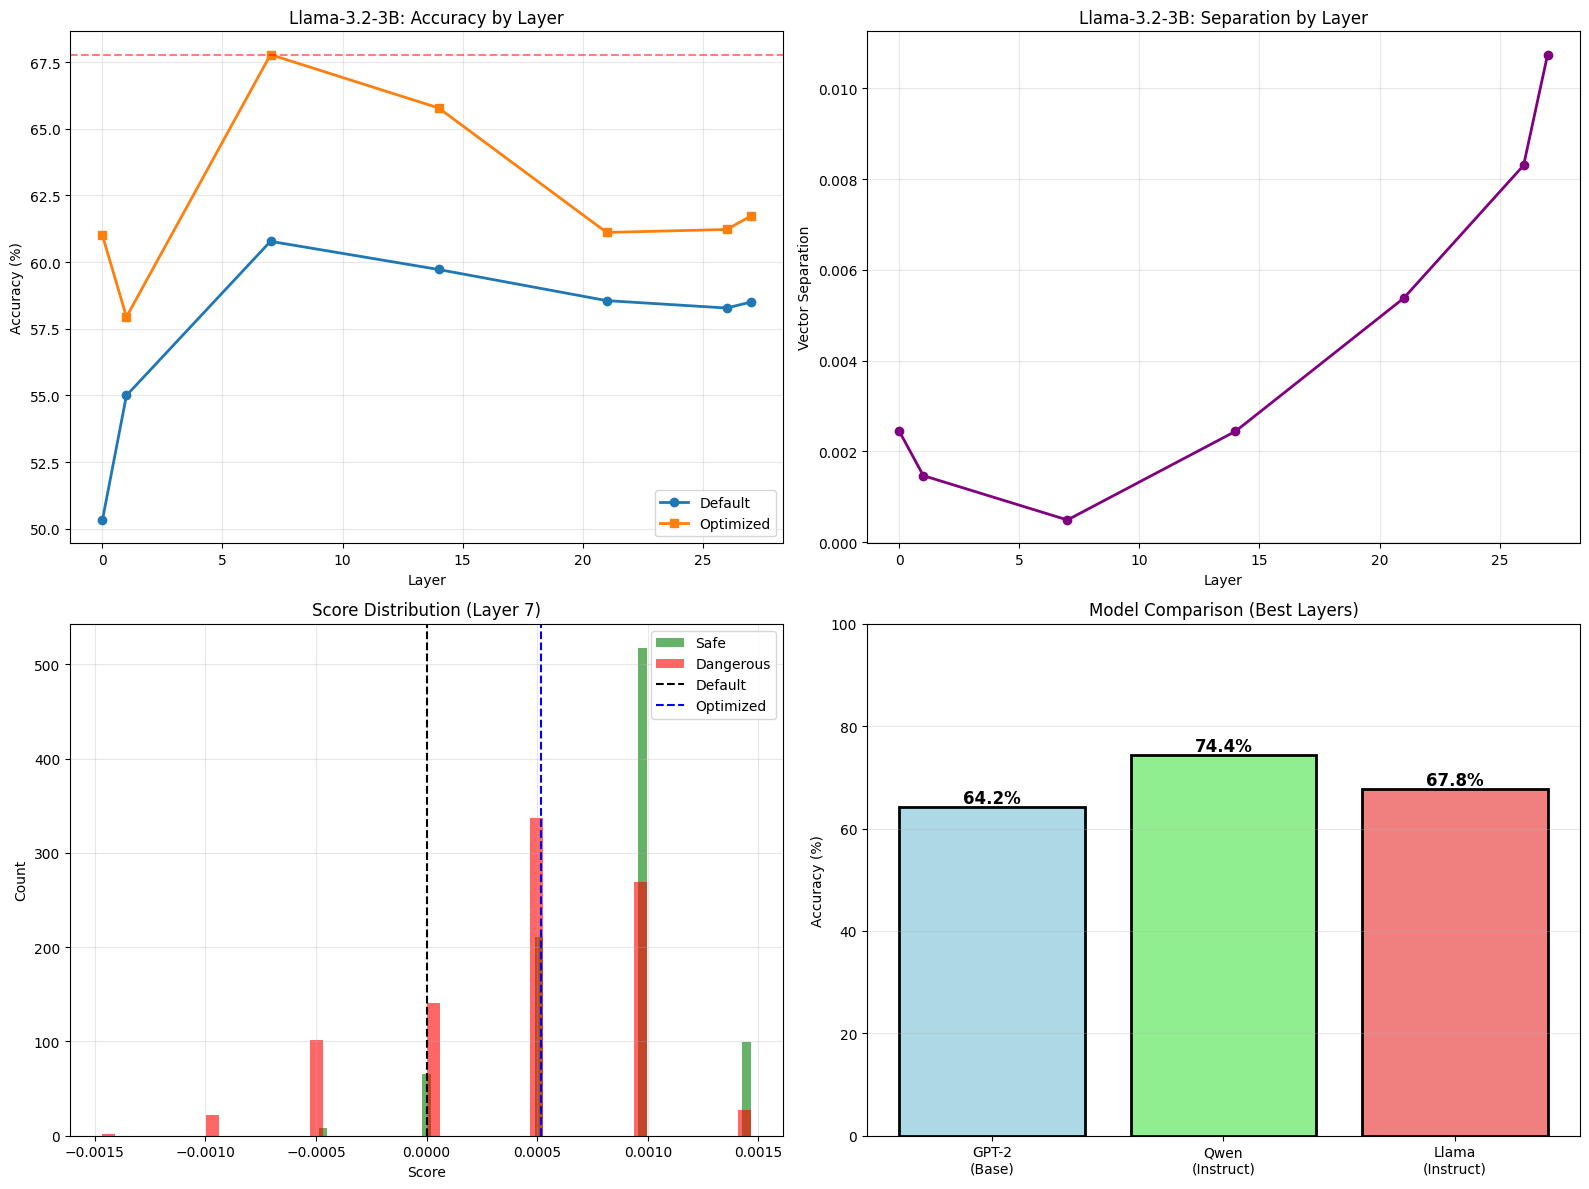


✓ Llama evaluation complete!

Best result: Layer 7, 67.8% accuracy


In [12]:
# ============================================================
# VISUALIZATIONS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Layer accuracy
ax = axes[0, 0]
layers = sorted(llama_layer_results.keys())
accs_default = [llama_layer_results[l]['accuracy_default']*100 for l in layers]
accs_opt = [llama_layer_results[l]['accuracy_optimized']*100 for l in layers]

ax.plot(layers, accs_default, marker='o', label='Default', linewidth=2)
ax.plot(layers, accs_opt, marker='s', label='Optimized', linewidth=2)
ax.axhline(y=max(accs_opt), color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Layer')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Llama-3.2-3B: Accuracy by Layer')
ax.legend()
ax.grid(alpha=0.3)

# Separation
ax = axes[0, 1]
seps = [llama_layer_results[l]['separation'] for l in layers]
ax.plot(layers, seps, marker='o', color='purple', linewidth=2)
ax.set_xlabel('Layer')
ax.set_ylabel('Vector Separation')
ax.set_title('Llama-3.2-3B: Separation by Layer')
ax.grid(alpha=0.3)

# Score distribution (best layer)
ax = axes[1, 0]
best_results = llama_layer_results[best_layer]['results']
scores = np.array(best_results['scores'])
labels_arr = np.array(best_results['true_labels'])

ax.hist(scores[labels_arr == 0], bins=50, alpha=0.6, label='Safe', color='green')
ax.hist(scores[labels_arr == 1], bins=50, alpha=0.6, label='Dangerous', color='red')
ax.axvline(0, color='black', linestyle='--', label='Default')
ax.axvline(llama_layer_results[best_layer]['threshold'], color='blue', linestyle='--', label='Optimized')
ax.set_xlabel('Score')
ax.set_ylabel('Count')
ax.set_title(f'Score Distribution (Layer {best_layer})')
ax.legend()
ax.grid(alpha=0.3)

# Model comparison (if available)
ax = axes[1, 1]
try:
    models = ['GPT-2\n(Base)', 'Qwen\n(Instruct)', 'Llama\n(Instruct)']
    accuracies = [
        gpt2_best[1]['accuracy_optimized'] * 100,
        qwen_best[1]['accuracy_optimized'] * 100,
        best_acc * 100
    ]
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    
    bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=2)
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Model Comparison (Best Layers)')
    ax.set_ylim([0, 100])
    ax.grid(axis='y', alpha=0.3)
    
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.1f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=12)
except:
    ax.text(0.5, 0.5, 'Comparison data unavailable', 
            ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.savefig('/kaggle/working/llama_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Llama evaluation complete!")
print(f"\nBest result: Layer {best_layer}, {best_acc*100:.1f}% accuracy")
